<a href="https://colab.research.google.com/github/TruthTreeASD/ml/blob/apar/ASD_clustering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os

In [56]:
data_folder = '../../data'
data_filename = 'RECleaned_StateData3.csv'
mapping_filename = 'mapping_id_name_state.csv'
data = pd.read_csv(os.path.join(data_folder, data_filename))
print(data.shape)
data.head()

(2098, 329)


,year,id,population,total_revenue,total_rev_own_sources,general_revenue,gen_rev_own_sources,total_taxes,property_tax,tot_sales___gr_rec_tax,...,prop_sale_total,air_trans_current_exp,educ_nec_current_exp,emp_sec_adm_current_exp,own_hospital_current_exp,toll_hwy_current_exp,libraries_current_exp,welf_ins_current_exp,sw_mgmt_current_exp,total_util_current_exp
0,2016,10000000,4858979,30172490,20650521,25288886,15766917,9919794,346277,5106102,...,0,997,340844,47216,0,0,3886,51106,0,75
1,2016,20000000,738432,8060170,5206968,7628651,4775449,1042164,111736,260846,...,373736,143090,48476,37907,0,117890,4817,51600,0,215320
2,2016,30000000,6828065,38241052,23700590,34582961,20042499,14676375,943008,8680009,...,111677,3945,51651,0,0,0,2509,34576,1079,27802
3,2016,40000000,2978204,21431620,14000079,20346096,12914555,9452883,1119958,4590072,...,45,389,140148,93573,0,0,2527,10826,9313,4356
4,2016,50000000,39144818,322332307,227996024,282907926,188571643,155231252,2513157,53365753,...,8749,4462,1042836,307593,0,0,23242,325039,560662,482860


In [57]:
supported_attributes = list(set([key for key in data.keys()]) - set(['year', 'id']))
supported_attributes

['chg_parks___recreation',
 'prot_insp_cap_outlay',
 'judicial_cap_outlay',
 'ltd_out_ffc_other_nec',
 'ltd_iss_ng_private_purp',
 'emp_ret_benefit_paymts',
 'welf_vend_pmts_medical',
 'total_capital_outlays',
 'local_igr_highways',
 'sw_mgmt_current_exp',
 'individual_income_tax',
 'total_educ_direct_exp',
 'fin_admin_direct_exp',
 'hous___com_direct_exp',
 'total_highways_cap_out',
 'pari_mutuels_tax',
 'total_ltd_retired',
 'unemp_int_revenue',
 'regular_hwy_current_exp',
 'tot_ltd_out_ng',
 'total_ig_expenditure',
 'property_tax',
 'welf_nec_cap_outlay',
 'air_trans_total_expend',
 'ltd_ret_gen_other_nec',
 'interest_on_gen_debt',
 'public_welf_total_exp',
 'tobacco_tax',
 'general_nec_ig_loc_govts',
 'unemp_comp_ben_paymts',
 'tot_sales___gr_rec_tax',
 'total_current_expend',
 'public_utility_tax',
 'ig_exp_to_federal_govt',
 'general_debt_interest',
 'natural_res_current_exp',
 'direct_expenditure',
 'total_other_capital_outlays',
 'corporation_license',
 'sinking_fd_cash___sec',

In [ ]:
def convert_to_pivot(data):
    pivoted = pd.pivot_table(data,
                             index='id', 
                             columns='year', 
                             values=list(set(data.keys())-set(['year', 'id'])))

    keys = list(set([key[0] for key in pivoted.keys()]))
    for i, key in enumerate(keys, 1):
        pivoted[key].iloc[:, 0] = pivoted[key].iloc[:, 0].fillna(0)
        pivoted[key].iloc[:, -1] = pivoted[key].iloc[:, -1].fillna(0)
        print(np.round(i/len(keys), 2), end='\r')

    pivoted = pivoted.interpolate(axis=1)

    print(' DONE !')
    return pivoted

In [5]:
def convert_to_pivot(data):
    pivoted = pd.pivot_table(data,
                             index='id', 
                             columns='year', 
                             values=list(set(data.keys())-set(['year', 'id'])))

    keys = list(set([key[0] for key in pivoted.keys()]))
    for i, key in enumerate(keys, 1):
        pivoted[key].iloc[:, 0] = pivoted[key].iloc[:, 0].fillna(0)
        pivoted[key].iloc[:, -1] = pivoted[key].iloc[:, -1].fillna(0)
        pivoted[key] = pivoted[key].interpolate(axis=1)
        print(np.round(i/len(keys), 2), end='\r')

    print(' DONE !')
    return pivoted

In [6]:
%%time
pivoted = convert_to_pivot(data)
pivoted.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


 DONE !
Wall time: 32.7 s


In [31]:
mapping = pd.read_csv(os.path.join(data_folder, mapping_filename))
mapping.head()

,id,name
0,10000000,ALABAMA
1,20000000,ALASKA
2,30000000,ARIZONA
3,40000000,ARKANSAS
4,50000000,CALIFORNIA


In [32]:
def getNearest(df1, df2, num):
    nbrs = NearestNeighbors(n_neighbors=num, algorithm='auto').fit(df1)
    distances, indices = nbrs.kneighbors(df2)
    
    return distances, indices

def getSimilarPlaces_singleAtt_multiYear(pivoted, name_id, attribute, norm_by=None, year_range=None, num=1):
    if norm_by:
        df = pivoted[attribute] / pivoted[norm_by]
    else:
        df = pivoted[attribute]
    df = df.replace([np.inf, -np.inf], np.nan)
    df.iloc[:, 0] = df.iloc[:, 0].fillna(0)
    df.iloc[:, -1] = df.iloc[:, -1].fillna(0)
    df = df.interpolate(axis=1)
    if year_range:
        df = df.loc[:, year_range[0]:year_range[1]]
    
    distances, indices = getNearest(df, np.asarray(df.loc[name_id]).reshape(1, -1), num+1)
    indices = indices[0]
    
    return df.iloc[indices].index.tolist(), distances

def getSimilarPlaces_multiAtt_singleYear(pivoted, name_id, attributes, year, norm_by=None, num=1):
    if norm_by:
        df = pivoted[attributes] / pivoted[norm_by]
    else:
        df = pivoted[attributes]
    df = df[[key for key in df.keys() if key[1]==year]]
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    distances, indices = getNearest(df, np.asarray(df.loc[name_id]).reshape(1, -1), num+1)
    indices = indices[0]
    
    return df.iloc[indices].index.tolist(), distances

In [36]:
name_id = mapping[mapping['name']=='WASHINGTON']['id'].iloc[0]
print(name_id)
attribute = 'total_expenditure'
norm_by = 'total_revenue'
yearRange = [2000, 2010]
num = 5

480000000


In [39]:
%%time
a, _ = getSimilarPlaces_singleAtt_multiYear(pivoted, name_id, attribute, norm_by, year_range=None, num=num)

Wall time: 11 ms


In [40]:
print(a)
print([mapping[mapping['id']==idx]['name'].values[0] for idx in a])

[480000000, 470000000, 140000000, 390000000, 450000000, 330000000]
['WASHINGTON', 'VIRGINIA', 'ILLINOIS', 'PENNSYLVANIA', 'UTAH', 'NEW YORK']


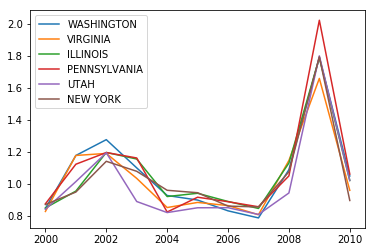

In [41]:
for idx in a:
    temp = pivoted[attribute].loc[idx]
    if norm_by:
        temp /= pivoted[norm_by].loc[idx]
    if yearRange:
        temp = temp.loc[yearRange[0]:yearRange[1]]
    plt.plot(temp)
plt.legend([mapping[mapping['id']==idx]['name'].values[0] for idx in a])

In [42]:
attributes = ['total_expenditure', 'total_revenue']
norm_by = 'population'
year = 2000
num=4

In [43]:
%%time
a, _ = getSimilarPlaces_multiAtt_singleYear(pivoted, name_id, attributes, year, norm_by, num)

Wall time: 15 ms


In [44]:
print(a)
print([mapping[mapping['id']==idx]['name'].values[0] for idx in a])

[480000000, 350000000, 50000000, 400000000, 230000000]
['WASHINGTON', 'NORTH DAKOTA', 'CALIFORNIA', 'RHODE ISLAND', 'MICHIGAN']
